# PRÁCTICA 3


***Competición en Kaggle***

---


**José María Sanchez Guerrero**


---




In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

# Utiles para seleccion de modelos
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve

# Pipelines
from sklearn.pipeline import make_pipeline

# Grid Search
from sklearn.model_selection import GridSearchCV

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Lectura de datos con pandas
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Mostramos los primeros datos y vemos sus características
df.head()

df = df.drop(['id'], axis=1)
sample = df_test['id'].to_frame()
df_test = df_test.drop(['id'], axis=1)

In [3]:
# Ordenamos por marca y eliminamos id para que sea mas facil lo demas
df = df.sort_values(['Potencia', 'Nombre'])

df['Descuento'] = df['Descuento'].fillna(0)
df_test['Descuento'] = df_test['Descuento'].fillna(0)
df['Nombre'] = df['Nombre'].ffill()

df['Consumo'] = df['Consumo'].replace(0, np.nan)

df = df.sort_values(['Nombre'])
df = df.ffill()
df = df.bfill()

df.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento,Precio_cat
677,Audi A3 35 TDI Attraction,D,2014.0,79271.0,Diesel,Automatic,First,20.38 kmpl,1968 CC,143 bhp,5.0,0.00,5
2104,Audi A3 35 TDI Premium,B,2016.0,20003.0,Diesel,Automatic,First,20.38 kmpl,1968 CC,143 bhp,5.0,0.00,5
1965,Audi A3 35 TDI Premium Plus,B,2016.0,39000.0,Diesel,Automatic,First,20.38 kmpl,1968 CC,143 bhp,5.0,42.89,5
3144,Audi A3 35 TDI Technology,J,2017.0,22000.0,Diesel,Automatic,Second,20.38 kmpl,1968 CC,143 bhp,5.0,0.00,5
716,Audi A4 1.8 TFSI,B,2011.0,53000.0,Petrol,Automatic,First,12.3 kmpl,1781 CC,163.2 bhp,5.0,0.00,4


In [4]:
x_train = df.copy()

x_train['Nombre'] = x_train['Nombre'].str.split(' ').str[0] + x_train['Nombre'].str.split(' ').str[1]
x_train['Consumo'] = x_train.Consumo.str.extract(r'(\d+[.\d]*)')
x_train['Motor_CC'] = x_train.Motor_CC.str.extract(r'(\d+[.\d]*)')
x_train['Potencia'] = x_train.Potencia.str.extract(r'(\d+[.\d]*)')

y_train = x_train['Precio_cat']
x_train = x_train.drop(['Precio_cat'], axis=1)

x_train.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento
677,AudiA3,D,2014.0,79271.0,Diesel,Automatic,First,20.38,1968,143,5.0,0.00
2104,AudiA3,B,2016.0,20003.0,Diesel,Automatic,First,20.38,1968,143,5.0,0.00
1965,AudiA3,B,2016.0,39000.0,Diesel,Automatic,First,20.38,1968,143,5.0,42.89
3144,AudiA3,J,2017.0,22000.0,Diesel,Automatic,Second,20.38,1968,143,5.0,0.00
716,AudiA4,B,2011.0,53000.0,Petrol,Automatic,First,12.3,1781,163.2,5.0,0.00


In [5]:
x_test = df_test.copy()

x_test['Nombre'] = x_test['Nombre'].str.split(' ').str[0] + x_test['Nombre'].str.split(' ').str[1]
x_test['Consumo'] = x_test.Consumo.str.extract(r'(\d+[.\d]*)')
x_test['Motor_CC'] = x_test.Motor_CC.str.extract(r'(\d+[.\d]*)')
x_test['Potencia'] = x_test.Potencia.str.extract(r'(\d+[.\d]*)')

x_test.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento
0,Mercedes-BenzNew,H,2015,77771,Diesel,Automatic,First,19.27,2143,170,5.0,0.0
1,Hyundaii10,J,2011,62000,Petrol,Manual,First,19.81,1086,68.05,5.0,0.0
2,FordFigo,C,2010,129986,Diesel,Manual,Second,20.0,1399,68,5.0,0.0
3,MarutiSwift,D,2015,49900,Petrol,Manual,First,20.85,1197,83.14,5.0,0.0
4,MarutiRitz,J,2010,75319,Petrol,Manual,Second,21.1,1197,85.80,5.0,0.0


In [6]:
from sklearn.preprocessing import LabelEncoder

# Codificamos las columnas representadas con cadenas para que se muestren como enteros

for col in ["Nombre", "Ciudad", "Combustible", "Tipo_marchas", "Mano"]:
    le = LabelEncoder()
    encoder = np.append(x_train[col].unique(), x_test[col].unique())
    le.fit(encoder)

    x_train[col] = le.transform(x_train[col].astype(str))
    x_test[col] = le.transform(x_test[col].astype(str))

In [7]:
x_train.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento
677,1,2,2014.0,79271.0,1,0,0,20.38,1968,143,5.0,0.00
2104,1,0,2016.0,20003.0,1,0,0,20.38,1968,143,5.0,0.00
1965,1,0,2016.0,39000.0,1,0,0,20.38,1968,143,5.0,42.89
3144,1,8,2017.0,22000.0,1,0,2,20.38,1968,143,5.0,0.00
716,2,0,2011.0,53000.0,4,0,0,12.3,1781,163.2,5.0,0.00


In [8]:
x_test.head()

,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Descuento
0,139,6,2015,77771,1,0,0,19.27,2143,170,5.0,0.0
1,76,8,2011,62000,4,1,0,19.81,1086,68.05,5.0,0.0
2,46,1,2010,129986,1,1,2,20.0,1399,68,5.0,0.0
3,122,2,2015,49900,4,1,0,20.85,1197,83.14,5.0,0.0
4,118,8,2010,75319,4,1,2,21.1,1197,85.80,5.0,0.0


              precision    recall  f1-score   support

           1       0.74      0.59      0.66       269
           2       0.53      0.36      0.43       602
           3       0.74      0.87      0.80      2211
           4       0.67      0.54      0.60       978
           5       0.81      0.87      0.84       759

    accuracy                           0.73      4819
   macro avg       0.70      0.65      0.67      4819
weighted avg       0.71      0.73      0.71      4819

SCORE:  0.7254617140485577


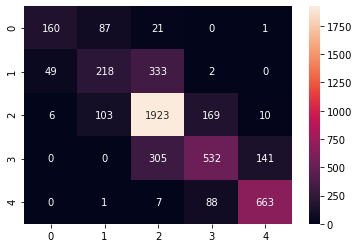

In [9]:
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('svr', make_pipeline(MinMaxScaler(),
                          LinearSVC()
                          )
    )]
RndForestClf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Calculo de las predicciones mediante validacion cruzada (5-folds)
y_pred = cross_val_predict(RndForestClf, x_train, y_train, cv=5)

print(classification_report(y_train, y_pred))
print("SCORE: ", accuracy_score(y_train, y_pred))

# Matriz de confusion de los resultados
confusion_matrix = confusion_matrix(y_train, y_pred)


sns.heatmap(confusion_matrix, annot = True, fmt='g')

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print(x_train.shape)
print(x_test.shape)

(4819, 12)
(1159, 12)


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

# Build the model

model = Sequential()

model.add(Dense(10, input_shape=(12,), activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# Adam optimizer with learning rate of 0.0001
optimizer = Adam(0.0001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


print('Neural Network Model Summary: ')
print(model.summary())

# Train the model
model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=300)

# Test on unseen data
predictions = model.predict(x_test)
labels = np.argmax(predictions, axis=-1)

8
Epoch 103/300
4819/4819 [==============================] - 0s 18us/step - loss: 0.7801 - acc: 0.6642
Epoch 104/300
4819/4819 [==============================] - 0s 18us/step - loss: 0.7777 - acc: 0.6645
Epoch 105/300
4819/4819 [==============================] - 0s 18us/step - loss: 0.7760 - acc: 0.6676
Epoch 106/300
4819/4819 [==============================] - 0s 17us/step - loss: 0.7737 - acc: 0.6678
Epoch 107/300
4819/4819 [==============================] - 0s 18us/step - loss: 0.7718 - acc: 0.6674
Epoch 108/300
4819/4819 [==============================] - 0s 18us/step - loss: 0.7698 - acc: 0.6703
Epoch 109/300
4819/4819 [==============================] - 0s 17us/step - loss: 0.7677 - acc: 0.6684
Epoch 110/300
4819/4819 [==============================] - 0s 17us/step - loss: 0.7660 - acc: 0.6730
Epoch 111/300
4819/4819 [==============================] - 0s 17us/step - loss: 0.7637 - acc: 0.6721
Epoch 112/300
4819/4819 [==============================] - 0s 17us/step - loss: 0.7621 - 

In [12]:
from sklearn.ensemble import RandomForestClassifier
RndForestClf = RandomForestClassifier(n_estimators=100)

# Train the model
RndForestClf.fit(x_train, y_train)

# Test on unseen data
#labels = RndForestClf.predict(x_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
sample["Precio_cat"] = np.round(labels).astype('int')

#sample.to_csv('sample.csv', index=False)